In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import utilities as ut
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dataset_paths = ut.images_paths("Images/WarpedCards/")
base_cards_paths = ut.images_paths("Images/Cards/")
work_dir= ut.Config.working_directory




In [2]:
def append_data(row):
    data=row["moments"].copy()
    data = np.append(data,row["hue"])
    return data

In [3]:
#Generating dataset using the generated images from Dataset_Generator.ipynb 
labels = []
hu_moments = []
average_hue=[]
samples=[]
for path in dataset_paths:
    properties = ut.label_properties_generated(path)
    samples.append(properties)
    image = cv2.imread(path)
    binary_image,contours = ut.preprocess_image(image)
    hue = ut.average_hue_of_contours(image, [contours[0]])
    average_hue.append(hue)
    moments = cv2.moments(contours[0])
    hu_moments.append(cv2.HuMoments(moments).flatten())
    
df_generated = pd.DataFrame(samples)
df_generated["moments"] = hu_moments
df_generated["hue"] = average_hue
df_generated["data"] = df_generated.apply(append_data,axis=1)
print(df_generated)

    value seed label index                                            moments  \
0       A    S    AS    18  [0.29045358552887396, 0.025157058959616625, 0....   
1       3    C     C     4  [0.2118486670456347, 0.013479124900986187, 0.0...   
2       R    B    RB    20  [0.2623287348167991, 0.03309892511102743, 0.00...   
3       7    C     C     5  [0.21178744404912664, 0.011739907437056978, 0....   
4       R    B    RB     2  [0.26265591020454726, 0.03327912711078298, 0.0...   
..    ...  ...   ...   ...                                                ...   
955     8    S    8S    18  [0.338024861895864, 0.054518291255381386, 0.00...   
956     6    S     S     6  [0.4958678287902063, 0.2038554043473707, 0.008...   
957     6    B     B    22  [0.31843991126901494, 0.07302001684453774, 0.0...   
958     7    C     C    15  [0.21955796759405496, 0.014767341109602981, 0....   
959     A    C    AC    11  [0.24345973933107223, 0.028748150616633977, 3....   

           hue             

In [4]:
labels = []
hu_moments = []
samples=[]
average_hue=[]
for path in base_cards_paths:
    samples.append(ut.label_class_only(path))
    image = cv2.imread(path)
    binary_image,contours = ut.preprocess_image(image)
    hue = ut.average_hue_of_contours(image, [contours[0]])
    average_hue.append(hue)
    moments = cv2.moments(contours[0])
    hu_moments.append(cv2.HuMoments(moments).flatten())
df_base = pd.DataFrame(samples)
df_base["moments"] = hu_moments
df_base["hue"] = average_hue
df_base["data"] = df_base.apply(append_data,axis=1)
print(df_base)


   value seed label                                            moments  \
0      7    C     C  [0.22225804081103337, 0.01594525095038476, 0.0...   
1      A    C    AC  [0.24305554848722474, 0.028763687428324046, 2....   
2      R    B     R  [0.26686700528342994, 0.03424285951895691, 0.0...   
3      7    S     7  [0.7296534270326875, 0.1525365272091704, 0.238...   
4      8    C     8  [0.40925092982787187, 0.10357475336507306, 0.0...   
5      4    O     4  [0.24825667613837687, 0.01543724752987511, 0.0...   
6      6    C     C  [0.248431159173635, 0.028764490485784156, 0.00...   
7      R    S     R  [0.26074346777962304, 0.030003292785587676, 0....   
8      4    C     C  [0.2142792002949413, 0.014672966581150875, 0.0...   
9      3    S    3S  [0.3549009320799103, 0.04035568095240079, 0.00...   
10     2    C    2C  [0.1870315616498156, 0.00036129249108887343, 0...   
11     5    S     5  [0.3911050708229767, 0.050549019411397944, 0.0...   
12     8    O     8  [0.44017008618482

In [5]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
scaling=StandardScaler()
scaling.fit(df_generated["data"].tolist())
Scaled_data=scaling.transform(df_generated["data"].tolist())
x=Scaled_data
print(x.shape)

(960, 8)


In [6]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x,df_generated["label"].tolist(), test_size=0.2, random_state=42)
f_clf = RandomForestClassifier(n_estimators=10)
f_clf = f_clf.fit(X_train,y_train)
predictions = f_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.9947916666666666
Classification Report:
              precision    recall  f1-score   support

          2B       1.00      1.00      1.00         6
          2C       1.00      1.00      1.00         5
          2S       1.00      1.00      1.00         4
          3B       1.00      1.00      1.00         5
          3S       1.00      1.00      1.00         9
          4O       1.00      1.00      1.00         5
          4S       1.00      1.00      1.00         8
          5S       1.00      1.00      1.00         2
          7S       1.00      1.00      1.00         8
          8B       1.00      1.00      1.00         5
          8C       1.00      1.00      1.00         5
          8O       1.00      1.00      1.00         5
          8S       1.00      1.00      1.00         6
          9B       1.00      0.86      0.92         7
          9C       1.00      1.00      1.00         8
          9O       0.83      1.00      0.91         5
          9S       1.00      

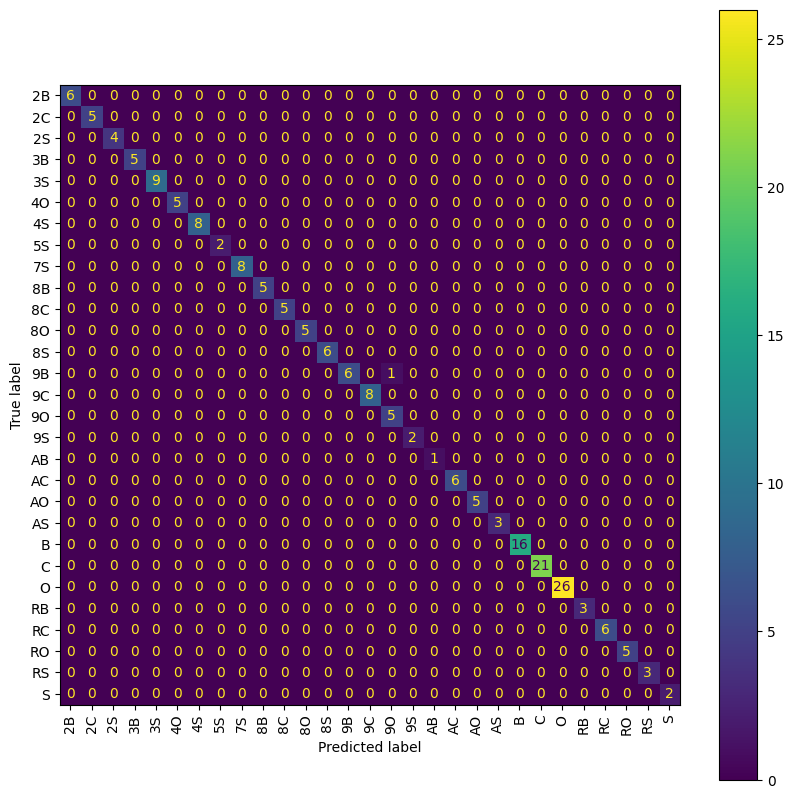

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=f_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=f_clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical')


In [8]:
import joblib
joblib.dump(f_clf,ut.Config.working_directory+"forest_classifier.sav")
joblib.dump(scaling,ut.Config.working_directory+"scaler.sav")

['workingDirectory/scaler.sav']